# 1. Data Setup

In [1]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/halleluyamengesha/Desktop/UChicago/_Quarter_3/Computer_Vision/Project


In [2]:
# Import libraries

import warnings

warnings.filterwarnings("ignore")

In [3]:
data_dir      = '/Users/halleluyamengesha/Desktop/UChicago/_Quarter_3/Computer_Vision/Project/data/old'
train_dir_00  = os.path.join(data_dir, 'train-00')
train_dir_01  = os.path.join(data_dir, 'train-01')
test_dir      = os.path.join(data_dir, 'test-00')

# Load data

# Train set
train00_files = [
    os.path.join(train_dir_00, f)
    for f in os.listdir(train_dir_00)
    if f.endswith('.png')
]
train01_files = [
    os.path.join(train_dir_01, f)
    for f in os.listdir(train_dir_01)
    if f.endswith('.png')
]

print(f"Train-00 images: {len(train00_files)}")
print(f"Train-01 images: {len(train01_files)}")

# Combine into a single training list
train_files = train00_files + train01_files
print(f"Combined training images: {len(train_files)}")

# Test set
test_files = [
    os.path.join(test_dir, f)
    for f in os.listdir(test_dir)
    if f.endswith('.png')
]
print(f"Test images: {len(test_files)}")


Train-00 images: 3760
Train-01 images: 6401
Combined training images: 10161
Test images: 5502


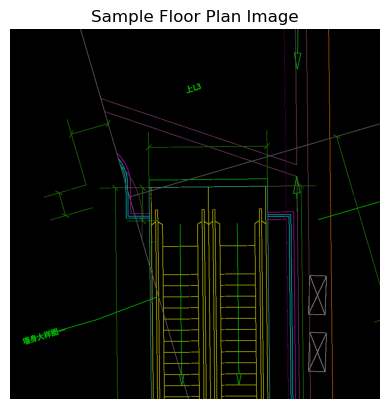

In [4]:
# View some samples

import cv2
import matplotlib.pyplot as plt

# View a random sample
img = cv2.imread(train_files[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Sample Floor Plan Image")
plt.axis('off')
plt.show()


In [5]:

print(os.listdir(data_dir)[:20])

['test-00.tar.xz', '.DS_Store', 'gt_masks_multiclass_test', 'train-01.tar.xz', 'train-00', 'train-01', 'gt_masks_multiclass', 'test-00', 'train', 'train-00.tar.xz']


## 2. Exploratory Data Analysis

*   **Summarize data: record counts, missing values, and schema**

In [6]:
# Record counts
print(f"Number of training images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

# Missing values check (basic)
missing_train = [file for file in train_files if not os.path.exists(file)]
missing_test = [file for file in test_files if not os.path.exists(file)]

print(f"\nMissing training files: {len(missing_train)}")
print(f"Missing testing files: {len(missing_test)}")

# Schema (example shape)
sample_image = cv2.imread(train_files[0])
print(f"\nSample image shape: {sample_image.shape}")  # (height, width, channels)


Number of training images: 10161
Number of test images: 5502

Missing training files: 0
Missing testing files: 0

Sample image shape: (1000, 1000, 3)


*   **Visualize the raw dataset using charts and tables (line/bar charts, q-q plots, heatmaps, violin, etc.)**

,file,num_classes,classes
0,0372-0015.svg,2,"[1, 3]"
1,0516-0007.svg,9,"[1, 3, 9, 18, 19, 23, 24, 29, 30]"
2,0771-0013.svg,3,"[1, 4, 30]"
3,0519-0344.svg,2,"[1, 35]"
4,0115-0001.svg,3,"[1, 4, 9]"


Images with only background: 2164 (21.7%)
Total images: 9958
Average classes/image: 4.45
Images with zero classes: 2164 (21.7%)
Min classes in any image: 0
Max classes in any image: 21


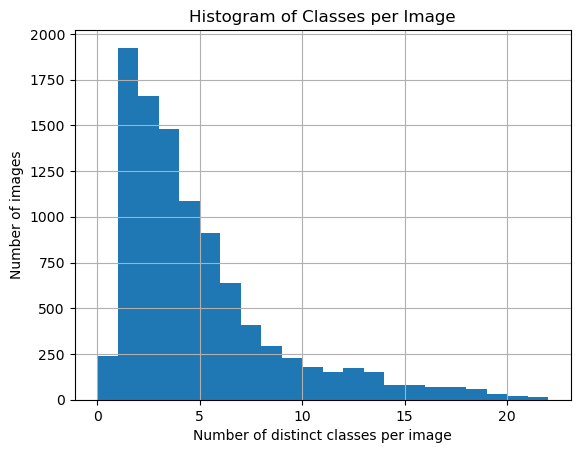

In [13]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

# Set path to your SVG folder
svg_dir = "/Users/halleluyamengesha/Desktop/UChicago/_Quarter_3/Computer_Vision/Project/data/old/train"

# Gather data
records = []
for svg_path in glob.glob(os.path.join(svg_dir, "*.svg")):
    tree = ET.parse(svg_path)
    sids = {
        int(el.get("semantic-id"))
        for el in tree.findall(".//{http://www.w3.org/2000/svg}path")
        if el.get("semantic-id") is not None
    }
    records.append({
        "file": os.path.basename(svg_path),
        "num_classes": len(sids),
        "classes": sorted(list(sids))
    })

# Create DataFrame
df = pd.DataFrame(records)

# Show a sample
display(df.head())   # or print(df.head())

# Summary stats
total_images = len(df)
avg_classes = df["num_classes"].mean()
no_class_count = (df["num_classes"] <= 1).sum()
min_classes = df["num_classes"].min()
max_classes = df["num_classes"].max()
pct_no_classes = no_class_count / len(df) * 100

print(f"Images with only background: {no_class_count} ({pct_no_classes:.1f}%)")
print(f"Total images: {total_images}")
print(f"Average classes/image: {avg_classes:.2f}")
print(f"Images with zero classes: {no_class_count} ({no_class_count/total_images*100:.1f}%)")
print(f"Min classes in any image: {min_classes}")
print(f"Max classes in any image: {max_classes}")

import matplotlib.pyplot as plt
plt.figure()
df['num_classes'].hist(bins=range(int(df['num_classes'].max()) + 2))
plt.xlabel("Number of distinct classes per image")
plt.ylabel("Number of images")
plt.title("Histogram of Classes per Image")
plt.show()

**Note**: *Each image is 1000 pixels height x 1000 pixels width x 3 color channels (RGB)*

*   **Structured Data: Perform univariate and bivariate analysis of the features**

In [7]:
import numpy as np
import pandas as pd
import random

# Sample a smaller subset
sampled_paths = random.sample(train_files, 500)  # Pick 500 images randomly

# Initialize feature storage
advanced_features = []

for path in sampled_paths:
    img = cv2.imread(path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape

        # Structured features
        file_size_kb = os.path.getsize(path) / 1024  # File size in KB
        aspect_ratio = w / h

        # Pixel statistical features
        mean_intensity = np.mean(gray)
        std_intensity = np.std(gray)

        # Edge detection
        edges = cv2.Canny(gray, threshold1=50, threshold2=150)
        edge_density = np.sum(edges > 0) / (h * w)

        # Collect all features
        advanced_features.append((
            os.path.basename(path), h, w, file_size_kb,
            aspect_ratio, mean_intensity, std_intensity, edge_density
        ))

# Create DataFrame
df_advanced = pd.DataFrame(advanced_features, columns=[
    'filename', 'height', 'width', 'file_size_kb',
    'aspect_ratio', 'mean_intensity', 'std_intensity', 'edge_density'
])

# Quick preview
df_advanced


,filename,height,width,file_size_kb,aspect_ratio,mean_intensity,std_intensity,edge_density
0,0094-0001.png,1000,1000,38.626953,1.0,3.465752,20.039793,0.020551
1,0421-0003.png,1000,1000,84.820312,1.0,8.673669,32.245557,0.041604
2,1306-0108.png,1000,1000,49.093750,1.0,4.681591,22.185036,0.035227
3,0777-0117.png,1000,1000,78.089844,1.0,7.146341,22.040148,0.103492
4,0538-0053.png,1000,1000,50.591797,1.0,5.449922,21.251316,0.073236
...,...,...,...,...,...,...,...,...
495,0108-0115.png,1000,1000,52.737305,1.0,2.982447,18.954982,0.019161
496,0133-0001.png,1000,1000,45.613281,1.0,5.964476,23.890822,0.056388
497,0014-0012.png,1000,1000,219.918945,1.0,11.726337,31.880286,0.090040
498,0392-0013.png,1000,1000,87.047852,1.0,2.896016,18.711013,0.020045


***NOTE: Feature	Interpretation***
* **height**: Image height (in pixels)
* **width**: 	Image width (in pixels)
* **aspect_ratio**:	width / height  

    - i.e. shape of the floor plan (e.g., square = 1.0, rectangle > 1.0 or < 1.0)

* **mean_intensity**:	Average pixel intensity (grayscale) across the whole image.
 
    - i.e. overall brightness: higher = brighter (more white), lower = darker

* **std_intensity**:	Standard deviation of pixel intensity.
    
    - i.e. how much variation/contrast exists: higher = more complex details (walls, doors)

* **edge_density**:	Ratio of edge pixels (detected by Canny Edge Detector) to total pixels
    
    - i.e. how "busy" the floor plan is (more edges = more walls, rooms, symbols)

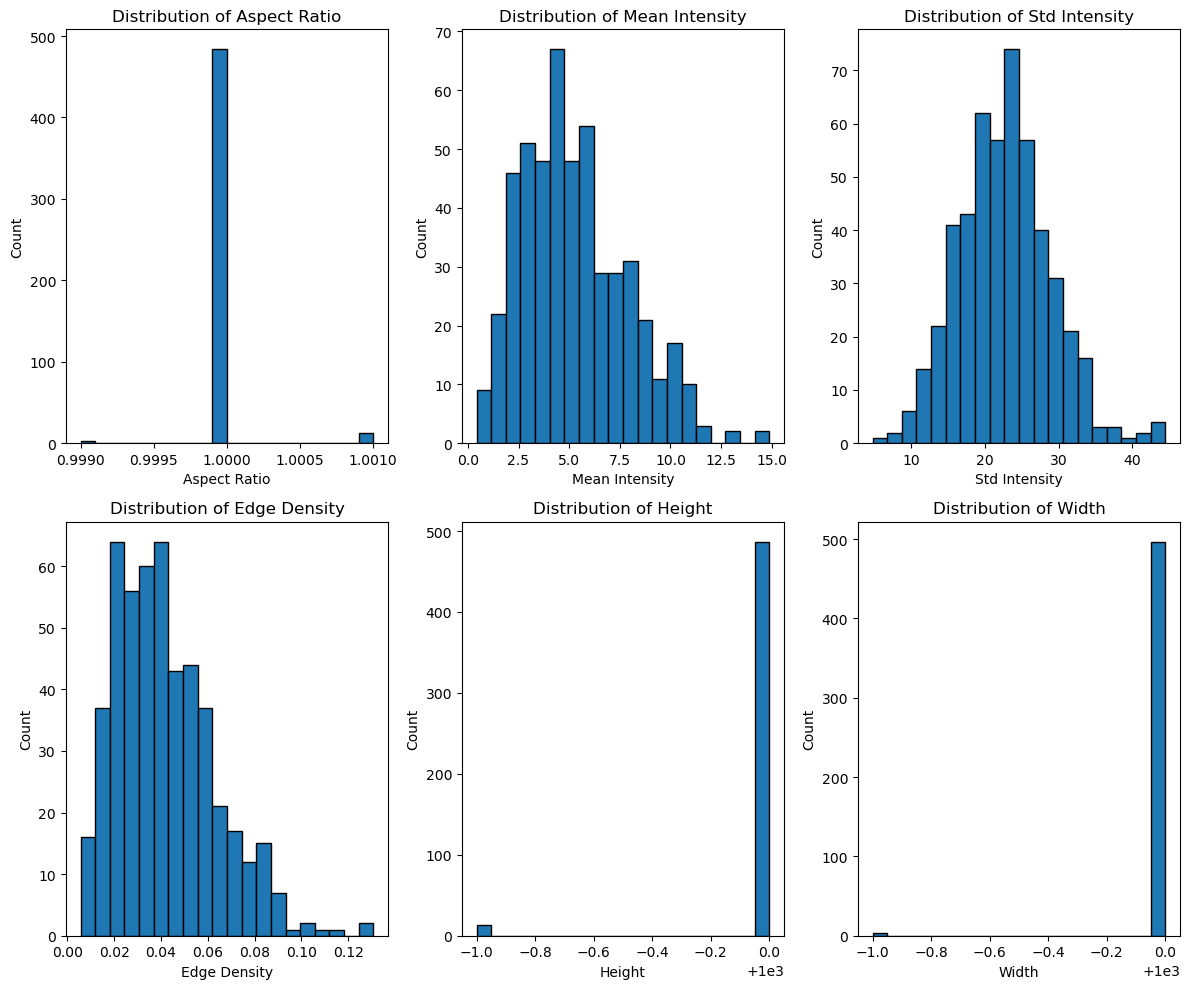

In [8]:
import matplotlib.pyplot as plt

features = ['aspect_ratio', 'mean_intensity', 'std_intensity', 'edge_density', 'height', 'width']

# Create a 2×2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Flatten the axes array so we can iterate in one loop
axes = axes.flatten()

for ax, feature in zip(axes, features):
    ax.hist(df_advanced[feature], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {feature.replace("_", " ").title()}')
    ax.set_xlabel(feature.replace("_", " ").title())
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


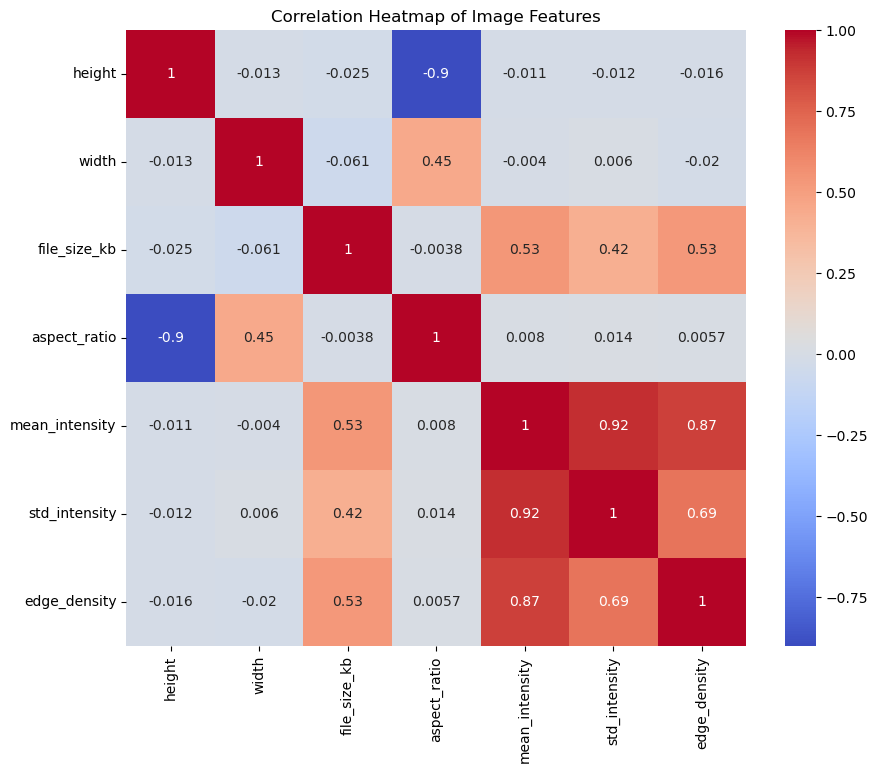

In [9]:
# Bivariate Analysis

import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df_advanced[['height', 'width', 'file_size_kb', 'aspect_ratio', 'mean_intensity', 'std_intensity', 'edge_density']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Image Features')
plt.show()


* **Image Data: Histograms, samples, outliers**

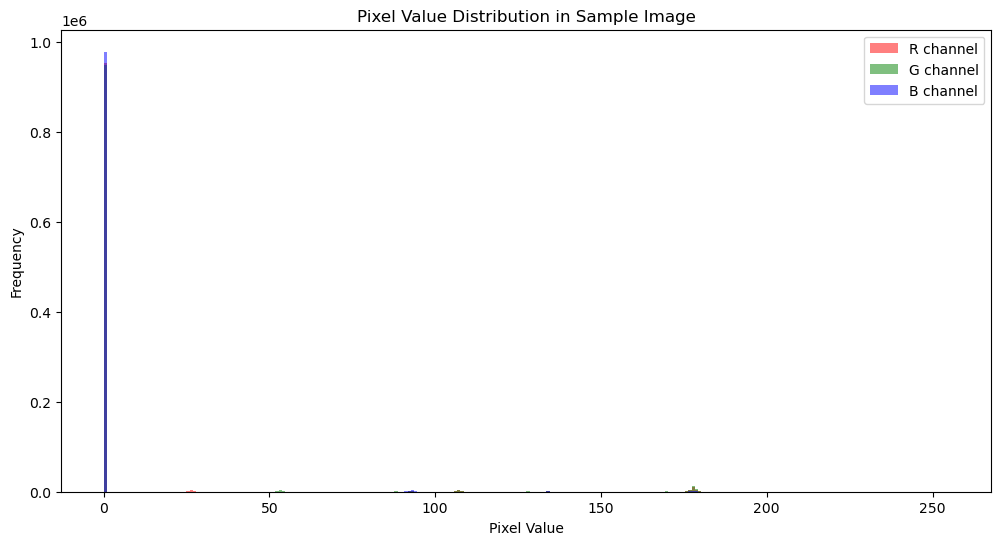

In [10]:
# Plot histogram of pixel values
img = cv2.imread(train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
colors = ('r', 'g', 'b')
for i, color in enumerate(colors):
    plt.hist(img[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
plt.legend()
plt.title('Pixel Value Distribution in Sample Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


***NOTE: Pixel Value Distribution Interpretation***
* Huge spike at pixel value = 0 (almost all pixels are black).
* Small bumps (minimized by huge spike at 0) around, say, 50 (G), 100 (B): correspond to the actual floor‑plan line colors.
* Tiny, nearly invisible counts for other pixel values.
* Y-axis is scaled because of the massive spike at 0, making other variations almost flat.

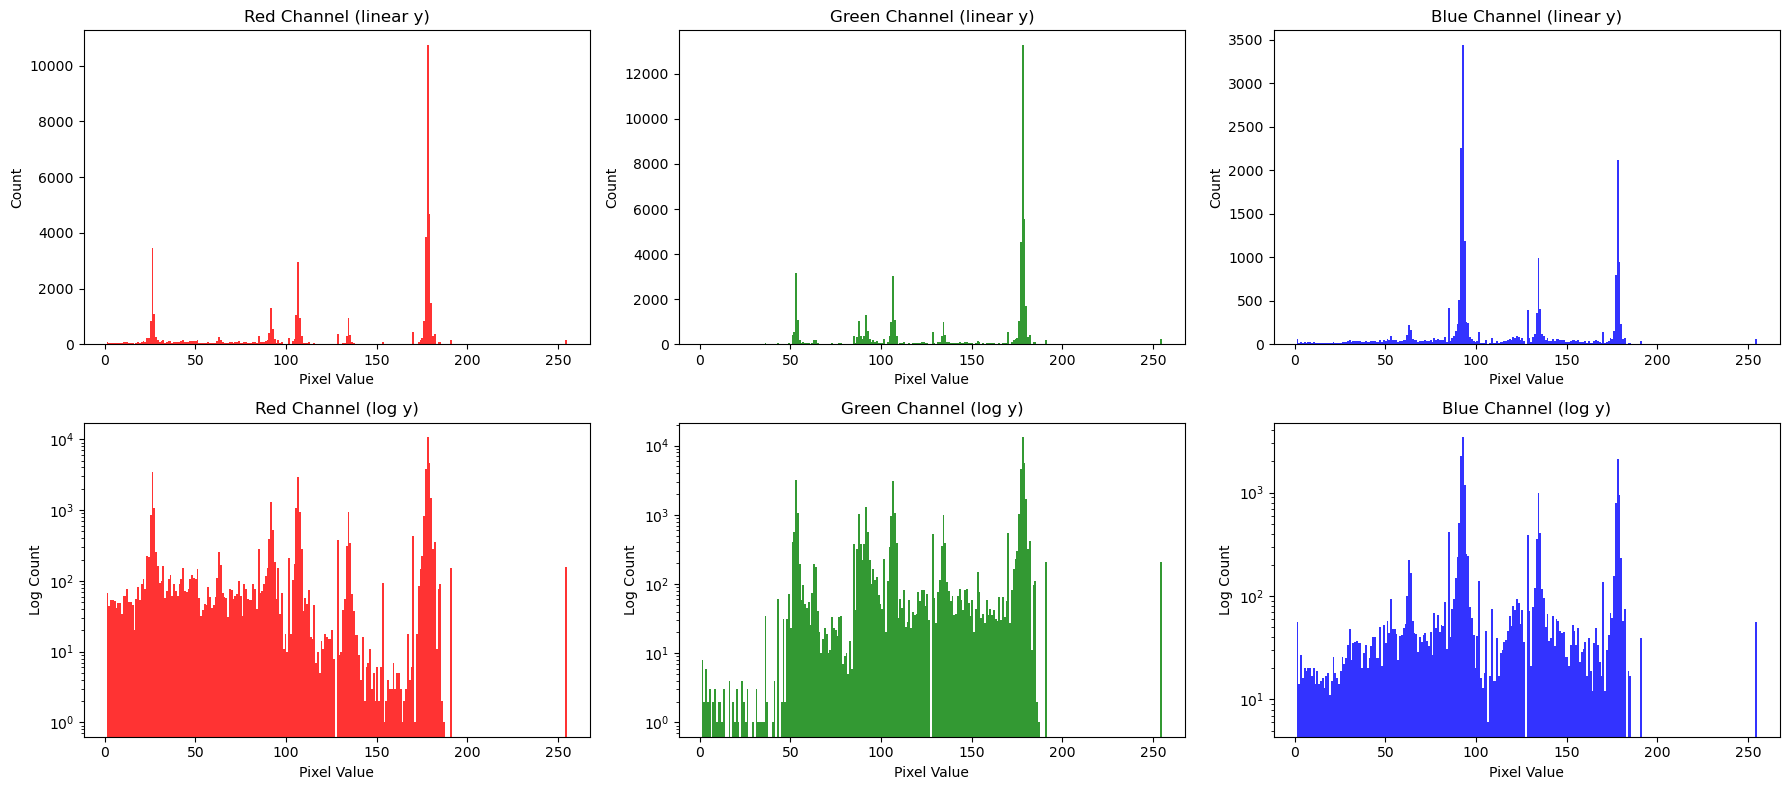

In [11]:
# Separate Re-plot each channel excluding pixel value = 0


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and convert one sample image
img = cv2.imread(train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Separate channels
r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]

# Mask out zeros
r_nz = r[r>0]
g_nz = g[g>0]
b_nz = b[b>0]

# Plot
plt.figure(figsize=(18, 8))

for idx, (chan, data, color) in enumerate([
    ('Red',   r_nz, 'red'),
    ('Green', g_nz, 'green'),
    ('Blue',  b_nz, 'blue'),
]):
    # Linear scale
    plt.subplot(2,3,idx+1)
    plt.hist(data.ravel(), bins=256, color=color, alpha=0.8)
    plt.title(f'{chan} Channel (linear y)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')

    # Log scale
    plt.subplot(2,3,idx+4)
    plt.hist(data.ravel(), bins=256, color=color, alpha=0.8)
    plt.yscale('log')
    plt.title(f'{chan} Channel (log y)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Log Count')

plt.tight_layout()
plt.show()


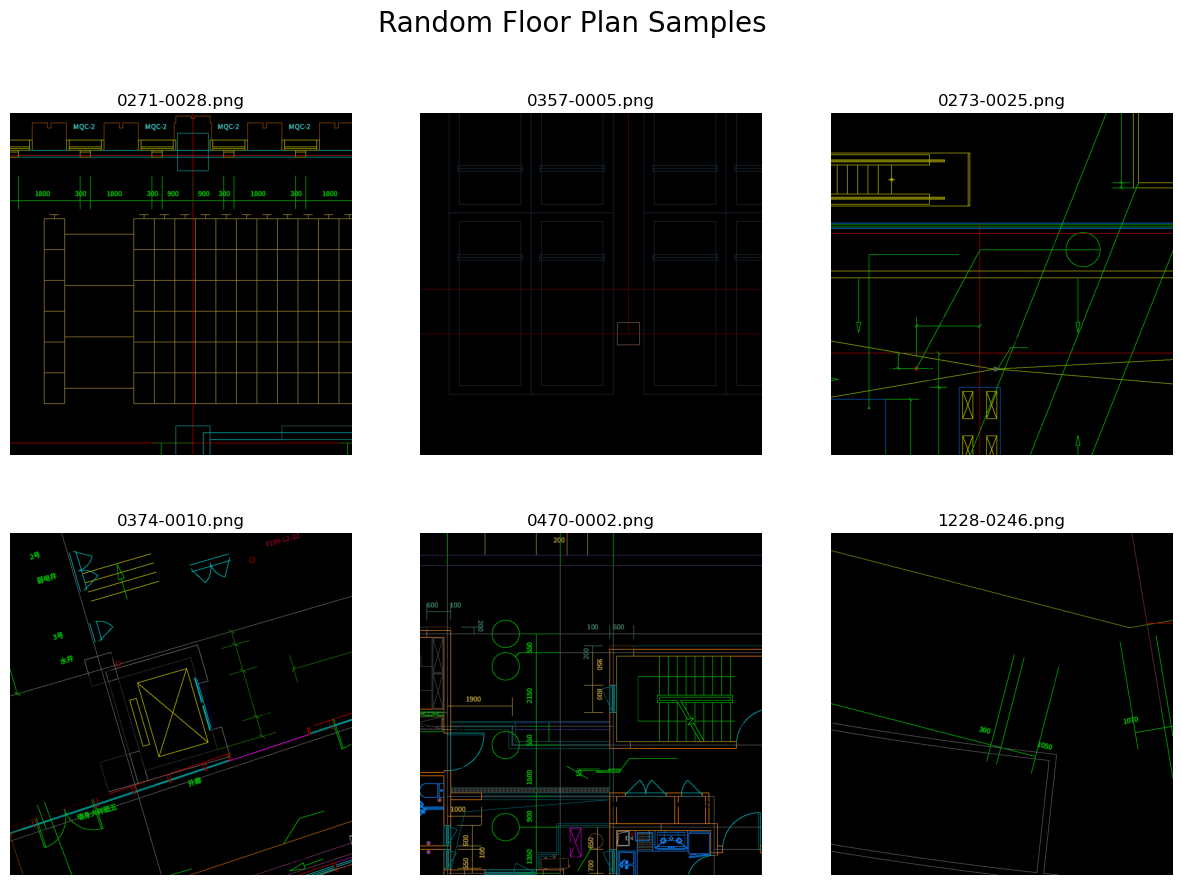

In [12]:
# Samples
import random

sample_paths = random.sample(train_files, 6)

plt.figure(figsize=(15, 10))
for idx, path in enumerate(sample_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(path))
plt.suptitle('Random Floor Plan Samples', fontsize=20)
plt.show()